<a href="https://colab.research.google.com/github/gauravshetty98/Gaurav-GIS-Repo/blob/main/map_ps0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug intake and its corelation with other factors like mental health

In this project I try to find a corelation if any exists between the intake of drugs and other factors like mental health.

I am making use of SAMHSA 2021 NSDUH: state specific tables for this project. It is a dataset which contains PDFs containing drug intake data along with mental health data for each state.

Dataset link: https://www.samhsa.gov/data/report/2021-nsduh-state-specific-tables

The code for data extraction from these PDFs is already present in the Github repository.

------------

### Importing Python Libraries

aok: cool; just also make maps per capita, ie divide drugs by population--ie CA and TX have many people so there will be lots of drugs because there are many people, but doesnt mean that there is more drug problem than elsewhere

In [60]:
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
#! pip install geopandas
!pip install mapclassify
import geopandas as gpd
import mapclassify
import mpl_toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable

#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )

## Mapping geographic map of USA

Since we are using data specific to the states of USA, we will be plotting a USA shape file.

In the code below, we first download the zip file from the internet. We then extract the zip file and search for USA shape file. Once found, we assign it to a variable and plot it.

In [2]:
! wget -q -O States_shapefile.zip https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/States_shapefile.zip

zip_ref = zipfile.ZipFile('States_shapefile.zip', 'r');
zip_ref.extractall();
zip_ref.close() #just unzipping
usa_shp = gpd.read_file('States_shapefile.shp') #load the shapefile with gpd as njC

<Axes: >

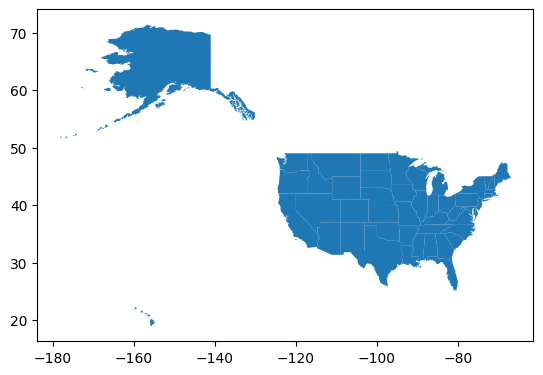

In [3]:
#make the map
usa_shp.plot()

We will not be looking into the statistics of ALASKA and HAWAI in this project hence dropping both the states from the shape file.

In [4]:
usa_shp = usa_shp.drop([1])
usa_shp = usa_shp.drop([11])

<Axes: >

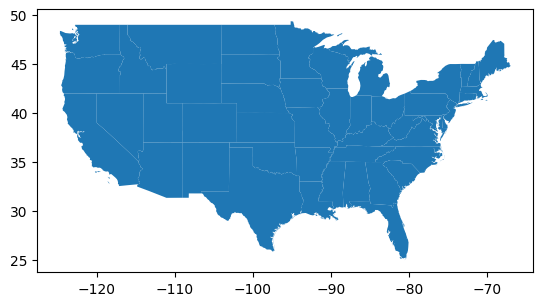

In [5]:
usa_shp.plot()

## Other Information from the shape file

Here we check the different datatypes and columns present in the shape file

In [6]:
usa_shp.dtypes #with geopandas can do stuff like with pandas :)

FID              int64
Program         object
State_Code      object
State_Name      object
Flowing_St      object
FID_1            int64
geometry      geometry
dtype: object

In [7]:
usa_shp.columns

Index(['FID', 'Program', 'State_Code', 'State_Name', 'Flowing_St', 'FID_1',
       'geometry'],
      dtype='object')

<Axes: >

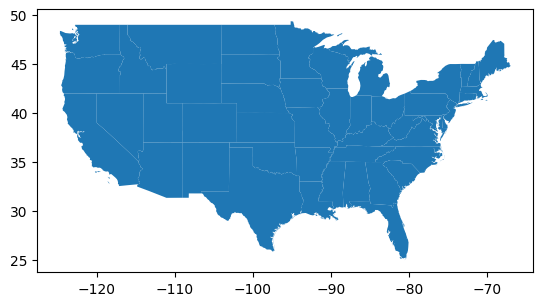

In [8]:
usa_shp.plot()

## Importing Drug Abuse Dataset

Here we import the drug use and mental health data extracted from NSDUH. We are importing this file from GitHub using `!wget`.

In [9]:
! wget https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/state_dataset.csv

dataset = pd.read_csv("state_dataset.csv")
dataset.head()

--2023-09-28 20:09:13--  https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/state_dataset.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/state_dataset.csv [following]
--2023-09-28 20:09:13--  https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/state_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168993 (165K) [text/plain]
Saving to: ‘state_dataset.csv’

state_dataset.csv   100%[===================>] 165.03K  --.-KB/s    in 0.004s  

2023-09-28 20:09:13 (38.1 MB/s) - ‘state_dataset.csv’ saved [168993/168993]



,index,Measure,12+,12-17,18-25,26+,18+,states
0,1,ILLICIT DRUGS Illicit Drug Use in the Past Mon...,403,17,98,288,386,Alabama
1,2,Marijuana Use in the Past Year,537,30,152,355,507,Alabama
2,3,Marijuana Use in the Past Month,315,16,90,209,299,Alabama
3,4,Perceptions of Great Risk from Smoking Marijua...,"1,128",105,83,940,"1,023",Alabama
4,6,First Use of Marijuana in the Past Year among ...,40,15,20,6,25,Alabama


### Making both DataFrames inline with each other

To make the merging easy, we change the state names to upper case and remove any spaces present in them.

We also change the Column name so that both dataframes have the same column names for states.

We also change the value for "District Of Columbia" so that both dataframes are inline with each other

In [10]:
dataset['states'] = dataset['states'].str.upper()
print(dataset.loc[1,'states'])

ALABAMA


In [11]:
usa_shp['State_Name'] = usa_shp['State_Name'].str.replace(' ', '')
print(usa_shp['State_Name'])

0                ALABAMA
2                ARIZONA
3               ARKANSAS
4             CALIFORNIA
5               COLORADO
6            CONNECTICUT
7               DELAWARE
8     DISTRICTOFCOLUMBIA
9                FLORIDA
10               GEORGIA
12                 IDAHO
13              ILLINOIS
14               INDIANA
15                  IOWA
16                KANSAS
17              KENTUCKY
18             LOUISIANA
19                 MAINE
20              MARYLAND
21         MASSACHUSETTS
22              MICHIGAN
23             MINNESOTA
24           MISSISSIPPI
25              MISSOURI
26               MONTANA
27              NEBRASKA
28                NEVADA
29          NEWHAMPSHIRE
30             NEWJERSEY
31             NEWMEXICO
32               NEWYORK
33         NORTHCAROLINA
34           NORTHDAKOTA
35                  OHIO
36              OKLAHOMA
37                OREGON
38          PENNSYLVANIA
39           RHODEISLAND
40         SOUTHCAROLINA
41           SOUTHDAKOTA


In [12]:
dataset = dataset.rename(columns = {'states':'State_Name'})
dataset['State_Name'] = dataset['State_Name'].replace('DISTRICTOFCOL','DISTRICTOFCOLUMBIA')
dataset.columns

Index(['index', 'Measure', '12+', '12-17', '18-25', '26+', '18+',
       'State_Name'],
      dtype='object')

### Merging both the datasets

We have created two different datasets which have the complete information using inner and outer join.

We are not using these datasets at the moment, these are only for knowledge purpose.

In [13]:
complete_df_outer = pd.merge(usa_shp, dataset, on = 'State_Name', how = 'outer', indicator = True)
complete_df_outer.to_csv("dataset_merged_outer.csv")

In [14]:
complete_df_inner = pd.merge(usa_shp, dataset, on = 'State_Name', how = 'inner', indicator = True)
complete_df_inner.to_csv("dataset_merged_inner.csv")

## Mapping Illicit Drug Usage in USA

We start of with creating a dataframe which contains quantitative data about the amount of illicit drugs being consumed in USA.

Note this plot does not take into account the population of each state

In [15]:
illicit_drug_df = pd.DataFrame(columns = dataset.columns)
for i in range(0,dataset.shape[0]):
  if dataset.iloc[i,1] == "ILLICIT DRUGS Illicit Drug Use in the Past Month1,2":
    illicit_drug_df.loc[len(illicit_drug_df.index)] = dataset.loc[i,:]
print(illicit_drug_df.head())

  index                                            Measure    12+ 12-17  \
0     1  ILLICIT DRUGS Illicit Drug Use in the Past Mon...    403    17   
1    44  ILLICIT DRUGS Illicit Drug Use in the Past Mon...    127     6   
2    87  ILLICIT DRUGS Illicit Drug Use in the Past Mon...  1,133    63   
3   130  ILLICIT DRUGS Illicit Drug Use in the Past Mon...    281    13   
4   173  ILLICIT DRUGS Illicit Drug Use in the Past Mon...  5,207   215   

   18-25    26+    18+  State_Name  
0     98    288    386     ALABAMA  
1     22     99    121      ALASKA  
2    306    764  1,070     ARIZONA  
3     62    206    268    ARKANSAS  
4  1,123  3,869  4,993  CALIFORNIA  


In [16]:
print(illicit_drug_df.shape)

(56, 8)


Here we merge the new dataframe with the geopanda dataframe usa_shp

In [17]:
drug_map = pd.merge(usa_shp, illicit_drug_df, on = 'State_Name', how = 'inner', indicator = False)

During reading the CSV file some columns were read as strings. We cant plot properly with string values. Here we convert these strings to integer datatype using `to_numeric()` function

In [18]:
drug_map['18+'] = drug_map['18+'].str.replace(",","")
drug_map['18+'] = pd.to_numeric(drug_map['18+'])

We have created a plot of State wise usage of Illicit Drugs.

All numbers are in thousands

<Axes: >

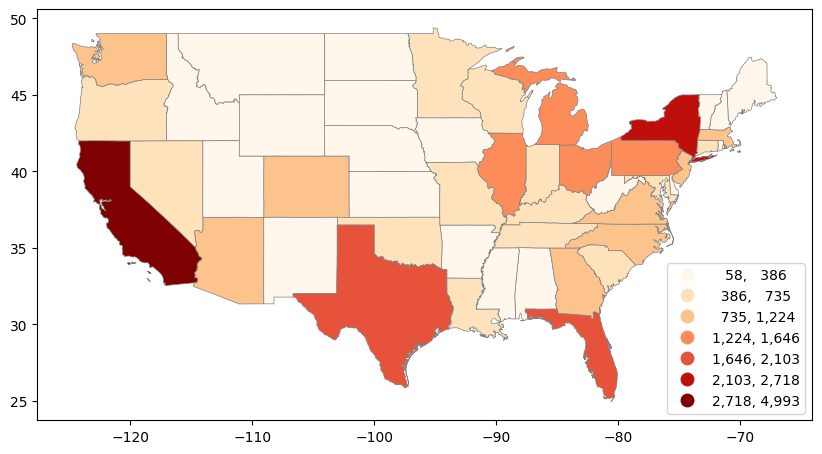

In [19]:
drug_map.plot(figsize=(10,12),column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1, 0.4),"fmt": "{:,.0f}"})

## Mapping Alcohol use in USA

We follow the same steps and try to produce a heatmap for Alcohol use in USA.

Note this plot does not take into account the population in each state.

In [20]:
alcohol_df = pd.DataFrame(columns = dataset.columns)
for i in range(0,dataset.shape[0]):
  if dataset.iloc[i,1] == "ALCOHOL Alcohol Use in the Past Month":
    alcohol_df.loc[len(alcohol_df.index)] = dataset.loc[i,:]
print(alcohol_df.head())

  index                                Measure     12+ 12-17  18-25     26+  \
0    16  ALCOHOL Alcohol Use in the Past Month   1,636    24    202   1,411   
1    59  ALCOHOL Alcohol Use in the Past Month     293     4     33     256   
2   102  ALCOHOL Alcohol Use in the Past Month   2,797    41    398   2,357   
3   145  ALCOHOL Alcohol Use in the Past Month     982    16    141     825   
4   188  ALCOHOL Alcohol Use in the Past Month  15,040   196  1,769  13,075   

      18+  State_Name  
0   1,613     ALABAMA  
1     289      ALASKA  
2   2,756     ARIZONA  
3     966    ARKANSAS  
4  14,844  CALIFORNIA  


In [21]:
alcohol_df['18+'] = alcohol_df['18+'].str.replace(",","")
alcohol_df['18+'] = pd.to_numeric(alcohol_df['18+'])
alcohol_map = pd.merge(usa_shp, alcohol_df, on = 'State_Name', how = 'inner', indicator = False)

<Axes: >

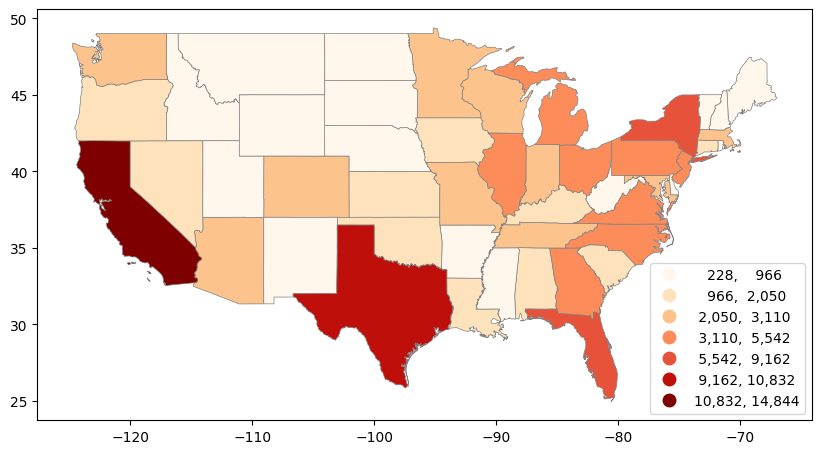

In [22]:
alcohol_map.plot(figsize=(10,12),column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1, 0.4),"fmt": "{:,.0f}"})

## Mental health issues reported in USA

We follow the same steps to create a heatmap for the mental health issues being reported in USA

Note this plot does not take into account the population in each state

In [23]:
mental_health_df = pd.DataFrame(columns = dataset.columns)
for i in range(0,dataset.shape[0]):
  if dataset.iloc[i,1] == "MENTAL HEALTH MEASURES IN THE PAST YEAR Any Mental Illness4,10":
    mental_health_df.loc[len(mental_health_df.index)] = dataset.loc[i,:]
print(mental_health_df.head())

  index                                            Measure 12+ 12-17  18-25  \
0    27  MENTAL HEALTH MEASURES IN THE PAST YEAR Any Me...   0     0    150   
1    70  MENTAL HEALTH MEASURES IN THE PAST YEAR Any Me...   0     0     26   
2   113  MENTAL HEALTH MEASURES IN THE PAST YEAR Any Me...   0     0    244   
3   156  MENTAL HEALTH MEASURES IN THE PAST YEAR Any Me...   0     0    100   
4   199  MENTAL HEALTH MEASURES IN THE PAST YEAR Any Me...   0     0  1,330   

     26+    18+  State_Name  
0    717    867     ALABAMA  
1    112    138      ALASKA  
2    970  1,214     ARIZONA  
3    424    524    ARKANSAS  
4  5,516  6,846  CALIFORNIA  


In [24]:
mental_health_df['18+'] = mental_health_df['18+'].str.replace(",","")
mental_health_df['18+'] = pd.to_numeric(mental_health_df['18+'])
mental_health_map = pd.merge(usa_shp, mental_health_df, on = 'State_Name', how = 'inner', indicator = False)

<Axes: >

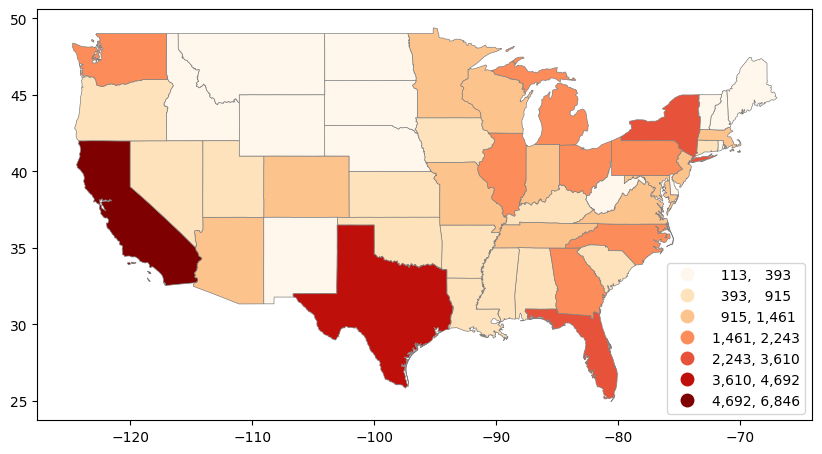

In [25]:
mental_health_map.plot(figsize=(10,12),column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1, 0.4),"fmt": "{:,.0f}"})

## Introducing the population element

We have mapped the amount of drugs being consumed in each state but we havent taken into consideration the population of each state. If we do not take the population of each state into consideration, these statistics can be a bit misleading.  

Dataset link: [Census Dataset](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjb16v2jLyBAxXbLzQIHSkFCrEQFnoECA4QAQ&url=https%3A%2F%2Fwww2.census.gov%2Fprograms-surveys%2Fpopest%2Ftables%2F2020-2022%2Fstate%2Fdetail%2FSCPRC-EST2022-18%2BPOP.xlsx&usg=AOvVaw1S9qPNFScgzhEtl1ADZne5&opi=89978449)

We start of importing the CENSUS estimates for population of each state for the age of 18 and above.

In [26]:
!wget -O population_data https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/SCPRC-EST2022-18%2BPOP.xlsx

--2023-09-28 20:09:23--  https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/SCPRC-EST2022-18%2BPOP.xlsx
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/SCPRC-EST2022-18%2BPOP.xlsx [following]
--2023-09-28 20:09:23--  https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/SCPRC-EST2022-18%2BPOP.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14025 (14K) [application/octet-stream]
Saving to: ‘population_data’

population_data     100%[===================>]  13.70K  --.-KB/s    in 0s      

2023-09-28 20:09:23 (79.3 MB/s) - ‘population

In [27]:
population =  pd.read_excel('population_data')
population.head(10)

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Estimates of the Total Resident Population and...,NaN,NaN,NaN
1,Geographic Area,Total Resident\nPopulation,Resident Population Age 18\n Years and Older,NaN
2,NaN,NaN,Number,Percent
3,United States,333287557,260836730,78.3
4,Northeast,57040406,45544589,79.8
5,Midwest,68787595,53626659,78
6,South,128716192,100098310,77.8
7,West,78743364,61567172,78.2
8,.Alabama,5074296,3962734,78.1
9,.Alaska,733583,557060,75.9


In [28]:
population.iloc[:,0] = population.iloc[:,0].str.upper()
population.iloc[:,0] = population.iloc[:,0].str.replace(".","")
population = population.iloc[8:59,0:3]
population.head(10)

<ipython-input-28-61cd5d5f3361>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  population.iloc[:,0] = population.iloc[:,0].str.replace(".","")


,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2
8,ALABAMA,5074296,3962734
9,ALASKA,733583,557060
10,ARIZONA,7359197,5770187
11,ARKANSAS,3045637,2348518
12,CALIFORNIA,39029342,30523315
13,COLORADO,5839926,4624351
14,CONNECTICUT,3626205,2895175
15,DELAWARE,1018396,810269
16,DISTRICT OF COLUMBIA,671803,547328
17,FLORIDA,22244823,17948469


In [29]:
population = population.rename(columns = {'table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)':'State_Name', 'Unnamed: 1':'Total Population', 'Unnamed: 2':'Above 18'})
population['State_Name'] = population['State_Name'].str.replace(' ', '')
population.columns

Index(['State_Name', 'Total Population', 'Above 18'], dtype='object')

In [30]:
usa_shp_pop_outer = pd.merge(usa_shp, population, on = 'State_Name', how = 'outer', indicator = 'exists')
usa_shp_pop_outer.to_csv("usa_shp_outer_with_population.csv")

usa_shp_pop_inner = pd.merge(usa_shp, population, on = 'State_Name', how = 'inner', indicator = 'exists')
usa_shp_pop_inner.to_csv("usa_shp_inner_with_population.csv")

Here we plot the population of USA to get an idea of population in each state which makes it easier for us to compare

<Axes: >

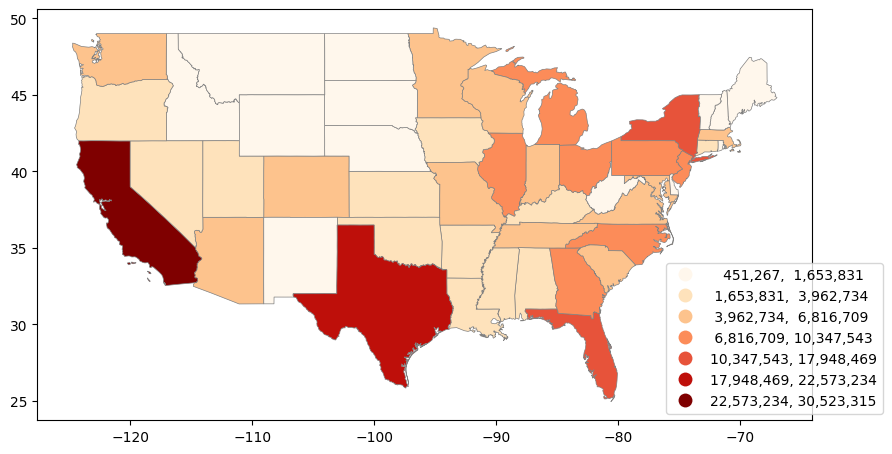

In [31]:
usa_shp_pop_inner.plot(figsize=(10,12),column='Above 18',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.1, 0.4),"fmt": "{:,.0f}"})

## Mapping Drug Use Based On Population

Here we have divided the drug use count of each state by its population to get a rough estimate of the percentage of people consuming illicit drugs

In [32]:
for i in range(0,drug_map.shape[0]):
  drug_map.iloc[i,13] = ((drug_map.iloc[i,13]*1000) / usa_shp_pop_inner.iloc[i,8])*100

drug_map.iloc[:,13]

0      9.740750
1     18.543593
2     11.411452
3     16.357987
4     20.500174
5     15.819424
6     16.907965
7     23.751754
8     11.716877
9     12.329293
10    11.723814
11    16.690494
12    13.357111
13    12.802763
14    13.399706
15    11.659946
16    14.793620
17    20.396644
18    15.255068
19    18.779210
20    19.635511
21    14.356700
22    13.527875
23    15.042440
24    17.545557
25    11.533979
26    19.614195
27    15.232332
28    13.470765
29    20.437397
30    17.325496
31    11.125530
32    10.897154
33    15.532700
34    17.543551
35    21.568259
36    14.989066
37    20.116383
38    12.461696
39     9.990458
40    12.043818
41     8.642980
42    11.146533
43    24.609859
44    13.041484
45    19.937409
46    14.614603
47    13.471317
48    12.852701
Name: 18+, dtype: float64

<Axes: >

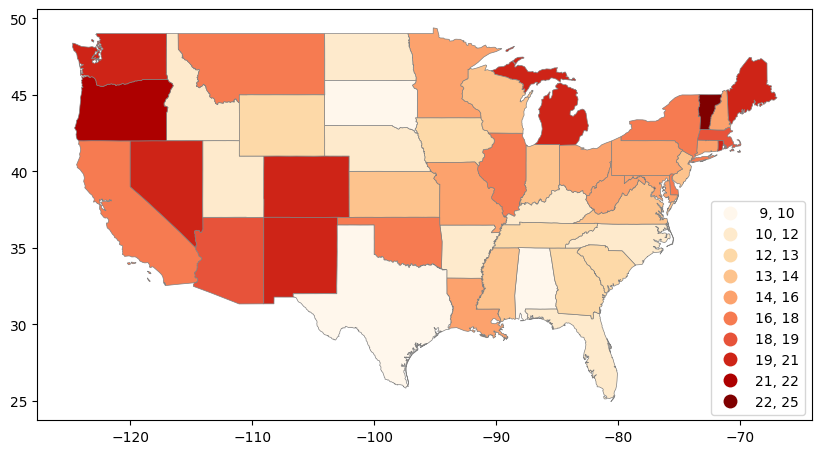

In [33]:
drug_map.plot(figsize=(10,12),column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=10, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1, 0.55),"fmt": "{:,.0f}"})

## Mapping Alcohol Use Based On Population

Here we have divided the alcohol consumption in each state by its population to give a rough estimate about the percentage of population consuming alcohol

In [34]:
for i in range(0,alcohol_map.shape[0]):
  alcohol_map.iloc[i,13] = ((alcohol_map.iloc[i,13]*1000) / usa_shp_pop_inner.iloc[i,8])*100

alcohol_map.iloc[:,13]

0     40.704221
1     47.762750
2     41.132323
3     48.631677
4     57.737832
5     59.720051
6     52.821964
7     62.850795
8     51.046137
9     46.008731
10    43.913477
11    52.768731
12    47.120393
13    57.430691
14    52.485890
15    41.308708
16    46.903145
17    51.255361
18    53.423870
19    55.097492
20    54.300518
21    56.838967
22    39.699451
23    49.178805
24    56.348230
25    56.664025
26    49.276646
27    61.542125
28    55.162716
29    48.009742
30    50.280908
31    45.989490
32    58.844633
33    54.146905
34    44.184965
35    58.034485
36    53.558608
37    56.191013
38    49.222501
39    55.743862
40    45.853571
41    47.986035
42    33.562089
43    59.364239
44    53.266173
45    49.420015
46    34.498895
47    60.986763
48    50.524412
Name: 18+, dtype: float64

<Axes: >

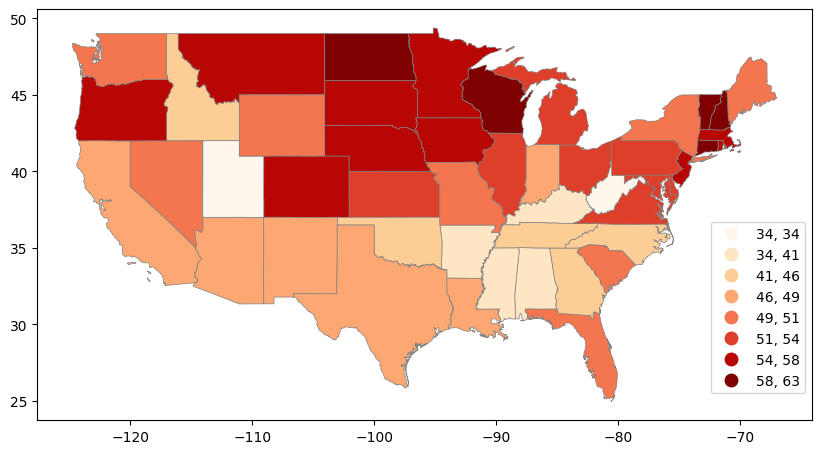

In [35]:
alcohol_map.plot(figsize=(10,12),column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1, 0.5),"fmt": "{:,.0f}"})

## Mapping Mental Health Based On Population

Here we have divided the Mental Health  in each state by its population to give a rough estimate about the percentage

In [36]:
for i in range(0,mental_health_map.shape[0]):
  mental_health_map.iloc[i,13] = ((mental_health_map.iloc[i,13]*1000) / usa_shp_pop_inner.iloc[i,8])*100

mental_health_map.iloc[:,13]

0     21.878834
1     21.039179
2     22.311943
3     22.428757
4     24.197990
5     19.791550
6     19.252865
7     27.953987
8     20.113136
9     22.278413
10    25.548427
11    21.243369
12    23.123193
13    24.717006
14    22.347682
15    22.464639
16    23.012299
17    22.682475
18    22.602407
19    22.464187
20    21.427441
21    24.440303
22    21.308614
23    23.872601
24    25.755977
25    23.403248
26    24.638323
27    21.535367
28    18.740738
29    23.763008
30    19.945355
31    21.596617
32    24.811982
33    23.832035
34    26.869676
35    26.886863
36    21.676643
37    25.398338
38    21.417791
39    22.297545
40    24.087635
41    20.785679
42    24.538705
43    24.797720
44    21.432630
45    26.110839
46    23.537942
47    23.305810
48    25.040608
Name: 18+, dtype: float64

<Axes: >

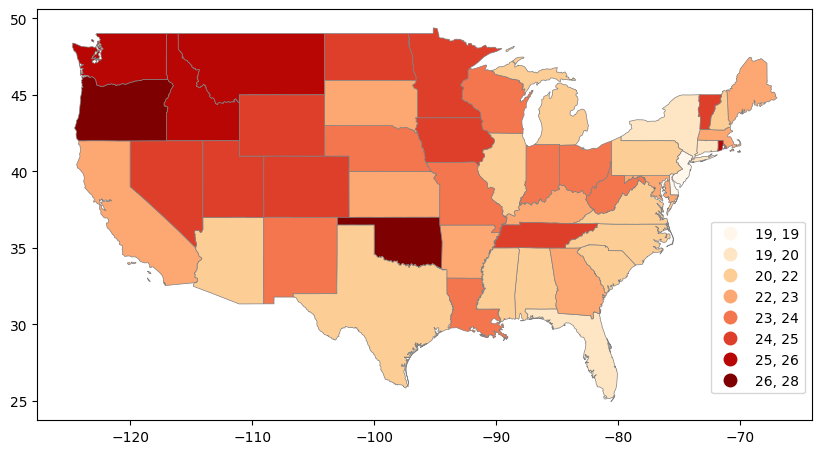

In [37]:
mental_health_map.plot(figsize=(10,12),column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1, 0.5),"fmt": "{:,.0f}"})

## Importing Crime rate dataset

We make use of State wise crime data published by the Federal Bureau of Investigation. We found this dataset in the FBI's Crime Data Explorer.

Dataset link: https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/downloads

We have three different excels which we need to merge and create one single dataframe.

In [38]:
!wget https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/Crimes_Against_Persons_Offenses_Offense_Category_by_State_2021.xlsx
!wget https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/Crimes_Against_Property_Offenses_Offense_Category_by_State_2021.xlsx
!wget https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/Crimes_Against_Society_Offenses_Offense_Category_by_State_2021.xlsx

--2023-09-28 20:09:33--  https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/Crimes_Against_Persons_Offenses_Offense_Category_by_State_2021.xlsx
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/Crimes_Against_Persons_Offenses_Offense_Category_by_State_2021.xlsx [following]
--2023-09-28 20:09:33--  https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/Crimes_Against_Persons_Offenses_Offense_Category_by_State_2021.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22257 (22K) [application/octet-stream]
Saving to: ‘Crimes_Against_Persons_O

In [39]:
crime_against_person = pd.read_excel("Crimes_Against_Persons_Offenses_Offense_Category_by_State_2021.xlsx",skiprows = [0,1,2,3])
crime_against_property = pd.read_excel("Crimes_Against_Property_Offenses_Offense_Category_by_State_2021.xlsx",skiprows = [0,1,2,3])
crime_against_society = pd.read_excel("Crimes_Against_Society_Offenses_Offense_Category_by_State_2021.xlsx",skiprows = [0,1,2,3])

Here you can see the three different datasets that I have imported

The crimes are divided into three different categories: crime against person, crime against property and crime against society.
Each category has its own CSV with much more details but, we will only be using the total count of each of these categories.

In [40]:
crime_against_person.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Total\nOffenses,Offense Category,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,State,Number\nof Participating\nAgencies,Population\nCovered,NaN,Assault\nOffenses,Homicide\nOffenses,Human\nTrafficking\nOffenses,Kidnapping/\nAbduction,Sex\nOffenses
1,Total,11794,215058917,2939412.0,2706772,16537,2141,36919,177043
2,Alabama,356,3734077,70855.0,68366,381,18,388,1702
3,Alaska,30,402557,6858.0,5945,31,2,29,851
4,Arizona,79,3949562,45372.0,40946,235,7,706,3478


In [41]:
crime_against_person.iloc[0,3] = "Total Offenses Against Person"
crime_against_person.columns = crime_against_person.iloc[0,:]
crime_against_person = crime_against_person.iloc[1:,:4]
crime_against_person.head()

,State,Number\nof Participating\nAgencies,Population\nCovered,Total Offenses Against Person
1,Total,11794,215058917,2939412.0
2,Alabama,356,3734077,70855.0
3,Alaska,30,402557,6858.0
4,Arizona,79,3949562,45372.0
5,Arkansas,285,2916168,66379.0


In [42]:
crime_against_property.iloc[0,3] = "Total Offenses Against Property"
crime_against_property.columns = crime_against_property.iloc[0,:]
crime_against_property = crime_against_property.iloc[1:,:4]
crime_against_property.head()

,State,Number of\nParticipating\nAgencies,Population\nCovered,Total Offenses Against Property
1,Total,11794,215058917,6531976.0
2,Alabama,356,3734077,122274.0
3,Alaska,30,402557,7301.0
4,Arizona,79,3949562,104648.0
5,Arkansas,285,2916168,123785.0


In [43]:
crime_against_society.iloc[0,3] = "Total Offenses Against Society"
crime_against_society.columns = crime_against_society.iloc[0,:]
crime_against_society = crime_against_society.iloc[1:,:4]
crime_against_society.head()

,State,Number of\nParticipating\nAgencies,Population\nCovered,Total Offenses Against Society
1,Total,11794,215058917,1620563.0
2,Alabama,356,3734077,30075.0
3,Alaska,30,402557,1730.0
4,Arizona,79,3949562,34213.0
5,Arkansas,285,2916168,38618.0


### Creating a master dataset for all three categories of offenses

Creating a single dataset for all the state wise crime data by merging the different dataframes into a single one

In [44]:
inter_df = pd.merge(crime_against_person, crime_against_property, on = 'State', how = 'outer', indicator = True)
crime_dataset = pd.merge(crime_against_society, inter_df, on = 'State',how = 'outer', indicator = 'exsits')

In [45]:
crime_dataset.to_csv("crime_master_dataset.csv")
crime_dataset.head()

,State,Number of\nParticipating\nAgencies _x,Population\nCovered,Total Offenses Against Society,Number\nof Participating\nAgencies,Population\nCovered _x,Total Offenses Against Person,Number of\nParticipating\nAgencies _y,Population\nCovered _y,Total Offenses Against Property,_merge,exsits
0,Total,11794,215058917,1620563.0,11794,215058917,2939412.0,11794,215058917,6531976.0,both,both
1,Alabama,356,3734077,30075.0,356,3734077,70855.0,356,3734077,122274.0,both,both
2,Alaska,30,402557,1730.0,30,402557,6858.0,30,402557,7301.0,both,both
3,Arizona,79,3949562,34213.0,79,3949562,45372.0,79,3949562,104648.0,both,both
4,Arkansas,285,2916168,38618.0,285,2916168,66379.0,285,2916168,123785.0,both,both


In [46]:
crime_dataset = crime_dataset.drop(crime_dataset.columns[[4,5,7,8]], axis=1)
crime_dataset.head()

,State,Number of\nParticipating\nAgencies _x,Population\nCovered,Total Offenses Against Society,Total Offenses Against Person,Total Offenses Against Property,_merge,exsits
0,Total,11794,215058917,1620563.0,2939412.0,6531976.0,both,both
1,Alabama,356,3734077,30075.0,70855.0,122274.0,both,both
2,Alaska,30,402557,1730.0,6858.0,7301.0,both,both
3,Arizona,79,3949562,34213.0,45372.0,104648.0,both,both
4,Arkansas,285,2916168,38618.0,66379.0,123785.0,both,both


The dataset has its own estimates of population based on the agencies that have provided the data. We are using the population estimates in the census data percentages.

Also the agencies which provided data for Florida did not have population calculations.

In [47]:
crime_dataset.iloc[:,0] = crime_dataset.iloc[:,0].str.upper()
crime_dataset.iloc[:,0] = crime_dataset.iloc[:,0].str.replace(".","")
crime_dataset.iloc[:,0] = crime_dataset.iloc[:,0].str.replace("1","")
crime_dataset.iloc[:,0] = crime_dataset.iloc[:,0].str.replace(" ","")

<ipython-input-47-494eafd216d5>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  crime_dataset.iloc[:,0] = crime_dataset.iloc[:,0].str.replace(".","")


In [48]:
crime_dataset = crime_dataset.iloc[1:,:]

You can run the below code cell to see the difference between the population estimates by census and the population covered in the FBI dataset.

In [49]:
for i in range(0,51):
  if crime_dataset.iloc[i,0] ==  population.iloc[i,0]:
    print("Crime:  ", crime_dataset.iloc[i,0],"Population: ", population.iloc[i,0], "Pop diff", (population.iloc[i,2] - crime_dataset.iloc[i,2]))

Crime:   ALABAMA Population:  ALABAMA Pop diff 228657
Crime:   ALASKA Population:  ALASKA Pop diff 154503
Crime:   ARIZONA Population:  ARIZONA Pop diff 1820625
Crime:   ARKANSAS Population:  ARKANSAS Pop diff -567650
Crime:   CALIFORNIA Population:  CALIFORNIA Pop diff 27661317
Crime:   COLORADO Population:  COLORADO Pop diff -1142234
Crime:   CONNECTICUT Population:  CONNECTICUT Pop diff -710422
Crime:   DELAWARE Population:  DELAWARE Pop diff -193115
Crime:   DISTRICTOFCOLUMBIA Population:  DISTRICTOFCOLUMBIA Pop diff -122722
Crime:   FLORIDA Population:  FLORIDA Pop diff nan
Crime:   GEORGIA Population:  GEORGIA Pop diff -306737
Crime:   HAWAII Population:  HAWAII Pop diff 83858
Crime:   IDAHO Population:  IDAHO Pop diff -413596
Crime:   ILLINOIS Population:  ILLINOIS Pop diff 2016265
Crime:   INDIANA Population:  INDIANA Pop diff 33991
Crime:   IOWA Population:  IOWA Pop diff -451807
Crime:   KANSAS Population:  KANSAS Pop diff -367902
Crime:   KENTUCKY Population:  KENTUCKY Pop d

In [50]:
crime_dataset = crime_dataset.rename(columns = {'State':'State_Name'})

In [51]:
crime_dataset_pop = pd.merge(crime_dataset, population, on = 'State_Name',how = 'outer', indicator = 'exsits_1')
crime_dataset_pop.columns

Index(['State_Name', 'Number of\nParticipating\nAgencies _x',
       'Population\nCovered ', 'Total Offenses Against Society',
       'Total Offenses Against Person', 'Total Offenses Against Property',
       '_merge', 'exsits', 'Total Population', 'Above 18', 'exsits_1'],
      dtype='object')

### Calculating Crime Rate Percentage

Here we calculate the percentage of crime rate based on the population esitimates given by CENSUS.

These percentages are an underestimation of the actual crime rate as there are many agencies and population missing in the FBI dataset.

In [52]:
for a in range(0,crime_dataset_pop.shape[0]):
  for b in range(3, crime_dataset_pop.shape[1]-5):
    crime_dataset_pop.iloc[a,b] = (crime_dataset_pop.iloc[a,b])/(crime_dataset_pop.iloc[a,-2])*100

crime_dataset_pop.head()

,State_Name,Number of\nParticipating\nAgencies _x,Population\nCovered,Total Offenses Against Society,Total Offenses Against Person,Total Offenses Against Property,_merge,exsits,Total Population,Above 18,exsits_1
0,ALABAMA,356,3734077,0.758946,1.788033,3.085597,both,both,5074296,3962734,both
1,ALASKA,30,402557,0.310559,1.231106,1.310631,both,both,733583,557060,both
2,ARIZONA,79,3949562,0.592927,0.786318,1.813598,both,both,7359197,5770187,both
3,ARKANSAS,285,2916168,1.644356,2.826421,5.270771,both,both,3045637,2348518,both
4,CALIFORNIA,15,2861998,0.085004,0.107154,0.266396,both,both,39029342,30523315,both


In [53]:
crime_dataset_pop.to_csv("crime_master_data_pop.csv")

In [54]:
crime_plot = pd.merge(usa_shp,crime_dataset_pop,on='State_Name',how='inner')
crime_plot.shape

(49, 17)

## Ploting the Crime Rate Across USA

Here we plot three different plots for the three categories of offenses defined.

Text(0.5, 1.0, 'Offenses Against Society')

Text(0.5, 1.0, 'Offenses Against Person')

Text(0.5, 1.0, 'Offenses Against Property')

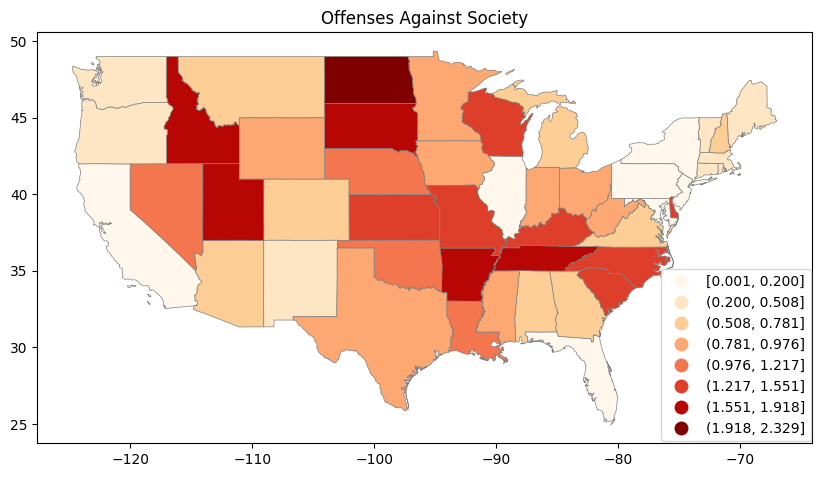

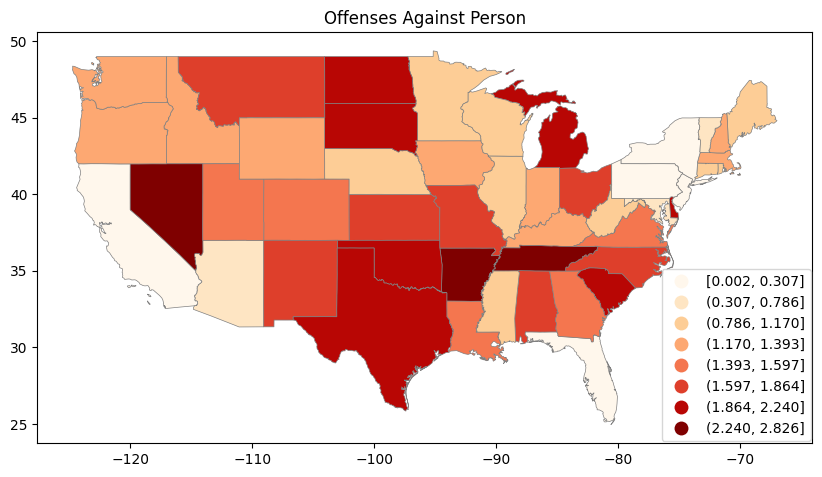

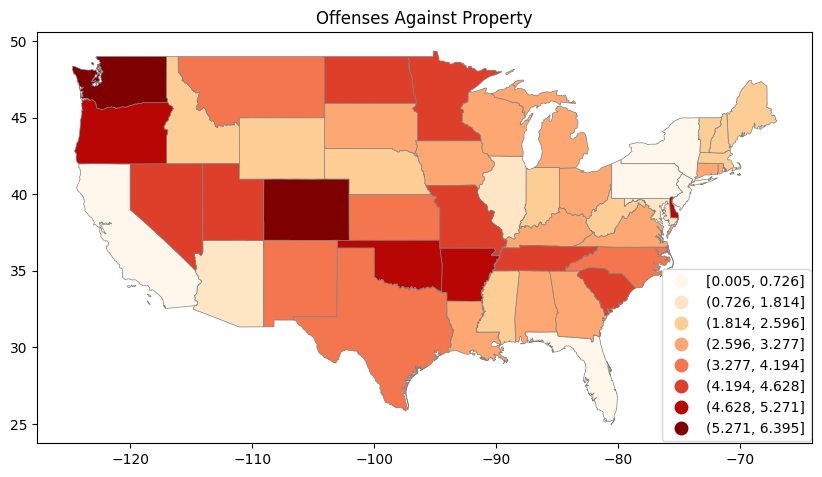

In [55]:
cps = crime_plot.plot(figsize=(10,12),column='Total Offenses Against Society',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.007, 0.44),"fmt": "{:,.3f}", "interval": True})
cps.set_title("Offenses Against Society")

#Code for adding state wise annotations:
# for i in range(0,crime_plot.shape[0]):
#   x,y = crime_plot.geometry[i].representative_point().x, crime_plot.geometry[i].representative_point().y
#   label = crime_plot.State_Code[i]
#   cps.annotate(label, xy = (x,y), xytext = (-5,-5), textcoords = "offset points")

cpp = crime_plot.plot(figsize=(10,12),column='Total Offenses Against Person',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.007, 0.44),"fmt": "{:,.3f}", "interval": True})
cpp.set_title("Offenses Against Person")

cppr = crime_plot.plot(figsize=(10,12),column='Total Offenses Against Property',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.007, 0.44),"fmt": "{:,.3f}", "interval": True})
cppr.set_title("Offenses Against Property")

plt.show()

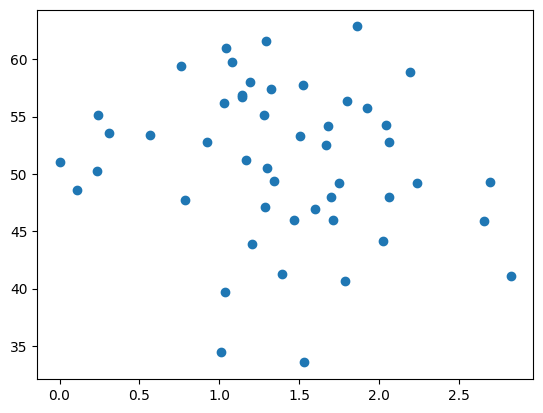

In [56]:
plt.scatter(crime_plot['Total Offenses Against Person'],alcohol_map['18+'])

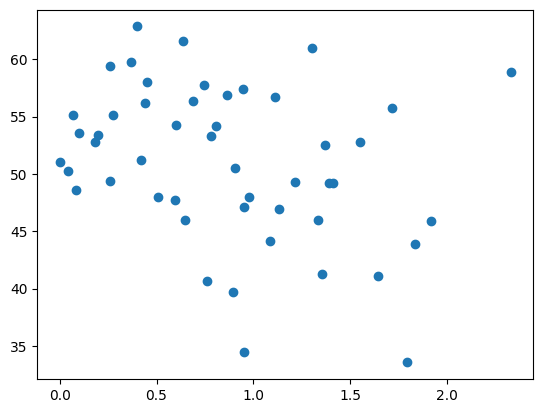

In [58]:
plt.scatter(crime_plot['Total Offenses Against Society'], alcohol_map['18+'])

In [59]:
master_df = pd.DataFrame(columns = ['State','A18+','D18+','MH18+','CAPrsn','CAS','CAProp'])
master_df['State'] = alcohol_map['State_Name']
master_df['A18+'] = alcohol_map['18+']
master_df['D18+'] = drug_map['18+']
master_df['MH18+'] = mental_health_map['18+']
master_df['CAPrsn'] = crime_plot['Total Offenses Against Person']
master_df['CAS'] = crime_plot['Total Offenses Against Society']
master_df['CAProp'] = crime_plot['Total Offenses Against Property']

In [61]:
fig = px.scatter_matrix(master_df)
fig.show()